# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/ccef/")
print(LOG_PATH)


/home/rco/github/s_metaheuristic/data/log/ccef


In [44]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [45]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [46]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [47]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [48]:
all_dfs = []
best_dfs = []
LOGs = str(LOG_PATH) + '/*.csv'

for file in glob.glob(str(LOGs)):
    df = pd.read_csv(file)
    filename = file[file.find('/log/')+5:]
    df['filename'] = filename
    all_dfs.append(df)
    best_dfs.append(df.iloc[-1:])

all_data = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
all_data.rename({'move_strategy':'move_str',
                 'selection_strategy':'selec_str'}, axis=1, inplace=True)

best_data = pd.concat(best_dfs, ignore_index=True).reset_index(drop=True)
best_data.rename({'move_strategy':'move_str',
                  'selection_strategy':'selec_str'}, axis=1, inplace=True)

In [49]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361 entries, 0 to 1360
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   iter        1361 non-null   int64  
 1   move        1361 non-null   object 
 2   improve     1360 non-null   object 
 3   obj         1360 non-null   float64
 4   return      1360 non-null   float64
 5   n_assets    1360 non-null   float64
 6   X           1360 non-null   object 
 7   Z           1360 non-null   object 
 8   qX          1360 non-null   float64
 9   qN          1360 non-null   float64
 10  qNv         1360 non-null   float64
 11  iter_time   1360 non-null   float64
 12  max_iter    1360 non-null   float64
 13  neighbours  1360 non-null   float64
 14  alpha       1360 non-null   float64
 15  exp_return  1360 non-null   float64
 16  n_port      1360 non-null   float64
 17  k_min       1360 non-null   float64
 18  k_max       1360 non-null   float64
 19  move_str    1360 non-null  

In [50]:
all_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
iter,1361.0,NaN,NaN,NaN,36.711976,29.428641,0.0,16.0,32.0,48.0,161.0
move,1361,4,idID,541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
improve,1360,2,False,1079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obj,1360.0,NaN,NaN,NaN,0.106332,0.101388,0.001389,0.002629,0.085095,0.208829,0.268654
return,1360.0,NaN,NaN,NaN,0.003627,0.001423,0.001025,0.00247,0.003303,0.004492,0.007097
n_assets,1360.0,NaN,NaN,NaN,4.804412,2.498266,2.0,2.0,5.0,7.0,10.0
X,1360,293,"[0.989279, 0.010721]",52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z,1360,95,"[25, 27]",157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qX,1360.0,NaN,NaN,NaN,4.804412,2.498266,2.0,2.0,5.0,7.0,10.0
qN,1360.0,NaN,NaN,NaN,1000.0,0.0,1000.0,1000.0,1000.0,1000.0,1000.0


## Portfólios

### Geral

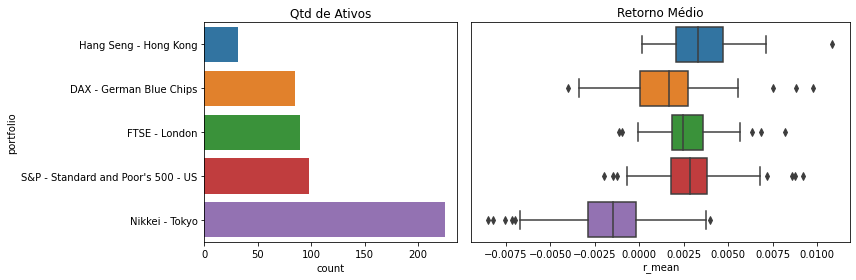

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

### Matriz de Covariância

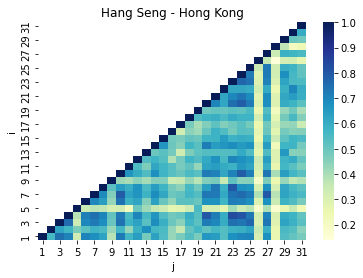

In [52]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [53]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


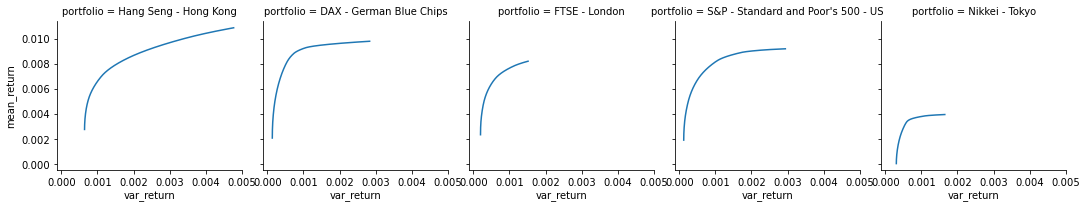

In [54]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

### Avaliação do Impacto da Seed

In [55]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

In [56]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='selec_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Tipo de Move

In [57]:
# g = sns.FacetGrid(
#     data=all_data, row='selec_str', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Impacto do Retorno Experado

In [58]:
# g = sns.FacetGrid(
#     data=all_data, row='exp_return', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

## Análise Best - Portfólio 1

In [59]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [60]:
print(best_data.shape)
best_data.head()

(21, 23)


,iter,move,improve,obj,return,n_assets,X,Z,qX,qN,...,neighbours,alpha,exp_return,n_port,k_min,k_max,move_str,seed,selec_str,filename
0,82,iDR,False,0.001457,0.002364,2.0,"[0.01055, 0.98945]","[25, 27]",2.0,1000.0,...,1000.0,0.1,0.002,1.0,2.0,10.0,random,33.0,first,ccef/log_local_search_20211101_231015.csv
1,50,iDR,False,0.256163,0.002862,10.0,"[0.026703, 0.083633, 0.21495, 0.03777, 0.08161...","[0, 1, 9, 12, 14, 16, 20, 21, 23, 29]",10.0,1000.0,...,1000.0,0.1,0.008,1.0,2.0,10.0,iDR,2.0,best,ccef/log_local_search_20211101_231020.csv
2,50,iDR,False,0.178917,0.003370,7.0,"[0.111464, 0.18865, 0.20082, 0.105178, 0.11022...","[13, 15, 18, 20, 23, 25, 29]",7.0,1000.0,...,1000.0,0.1,0.009,1.0,2.0,10.0,iDR,29.0,best,ccef/log_local_search_20211101_231003.csv
3,50,TID,False,0.225459,0.003303,7.0,"[0.129814, 0.138679, 0.101401, 0.213359, 0.150...","[5, 10, 12, 14, 18, 26, 29]",7.0,1000.0,...,1000.0,0.1,0.008,1.0,2.0,10.0,TID,54.0,first,ccef/log_local_search_20211101_231001.csv
4,50,idID,False,0.200264,0.004429,4.0,"[0.272426, 0.24253, 0.298569, 0.186475]","[8, 10, 13, 19]",4.0,1000.0,...,1000.0,0.1,0.010,1.0,2.0,10.0,idID,24.0,random,ccef/log_local_search_20211101_230959.csv


In [61]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,21.0,63.666667,2.575332e+01,50.000000,50.000000,50.000000,68.000000,161.000000
obj,21.0,0.118820,1.075939e-01,0.001389,0.002201,0.159049,0.208829,0.268654
return,21.0,0.003712,1.479043e-03,0.001722,0.002470,0.003327,0.004492,0.007092
n_assets,21.0,4.761905,2.773171e+00,2.000000,2.000000,5.000000,7.000000,10.000000
qX,21.0,4.761905,2.773171e+00,2.000000,2.000000,5.000000,7.000000,10.000000
qN,21.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
qNv,21.0,288.285714,3.573364e+02,0.000000,0.000000,0.000000,590.000000,991.000000
iter_time,21.0,0.355896,1.419226e-01,0.257682,0.315397,0.331682,0.340862,0.955375
max_iter,21.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,21.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


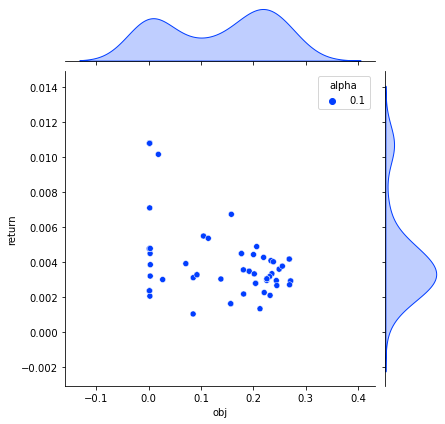

In [41]:
sns.jointplot(data=best_data, x='obj', y='return', hue='alpha', palette='bright')

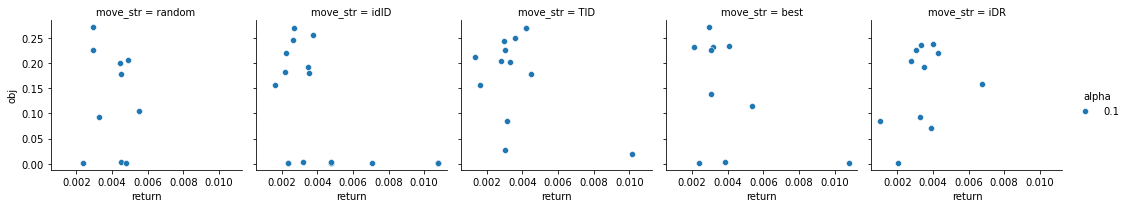

In [42]:
g = sns.FacetGrid(data=best_data, col='move_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

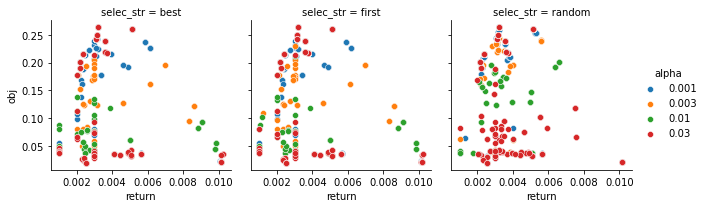

In [21]:
g = sns.FacetGrid(data=best_data, col='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

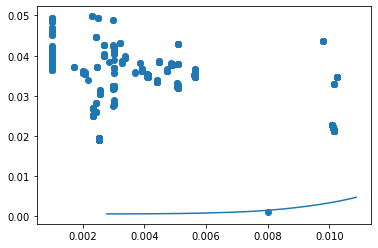

In [131]:
data = best_data[best_data['obj']<0.05]
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.scatter(data['return'], data.obj)

In [ ]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  \
move_str selec_str                                                           
TID      best          33     34     35     37     33     35     32     31   
         first         36     33     36     32     32     35     33     37   
         random        37     35     33     36     33     31     37     36   
best     best          34     28     34     36     37     34     35     31   
         first         38     36     39     34     36     31     36     32   
         random        36     37     32     36     37     31     34     35   
iDR      best          41     32     30     27     30     33     37     34   
         first         40     37     34     35     36     36     34     33   
         random        40     35     31     33     34     37     32     35   
idID     best          42     36     36     35     31     34     36     39   
         first         39     34     38     37     33     36     35     32   
         random        36     37     37     32     36     34     28     33   
random   best          35     33     37     35     28     34     35     33   
         first         35     30     28     34     36     35     36     36   
         random        36     35     31     34     31     33     37     35   

exp_return          0.009  0.010  
move_str selec_str                
TID      best          33     35  
         first         37     37  
         random        35     30  
best     best          36     30  
         first         34     34  
         random        37     32  
iDR      best          37     34  
         first         37     34  
         random        37     33  
idID     best          38     34  
         first         37     28  
         random        34     37  
random   best          33     37  
         first         35     38  
         random        35     30

In [ ]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return             0.001     0.002     0.003     0.004     0.005  \
move_str selec_str                                                     
TID      best       0.019076  0.019076  0.021210  0.021210  0.021210   
         first      0.019076  0.019076  0.021210  0.021210  0.021210   
         random     0.043192  0.043192  0.043192  0.101604  0.101604   
best     best       0.019111  0.019111  0.021256  0.021256  0.021256   
         first      0.019111  0.019111  0.021256  0.021256  0.021256   
         random     0.019111  0.019110  0.021436  0.021283  0.021283   
iDR      best       0.024889  0.024889  0.033003  0.034657  0.054469   
         first      0.024889  0.024889  0.033003  0.034657  0.034657   
         random     0.025054  0.025054  0.095344  0.118208  0.118208   
idID     best       0.019109  0.019109  0.021273  0.021273  0.021273   
         first      0.019109  0.019109  0.021273  0.021273  0.021273   
         random     0.019109  0.019109  0.021250  0.021251  0.021252   
random   best       0.019111  0.019110  0.021272  0.021272  0.021272   
         first      0.019110  0.019110  0.021272  0.021272  0.021272   
         random     0.019113  0.019111  0.021254  0.021256  0.021254   

exp_return             0.006     0.007     0.008     0.009     0.010  
move_str selec_str                                                    
TID      best       0.190141  0.190141  0.190141  0.190141  0.190141  
         first      0.190141  0.190141  0.190141  0.190141  0.190141  
         random     0.190141  0.190141  0.190141  0.190141  0.190141  
best     best       0.021256  0.021256  0.190141  0.190141  0.190141  
         first      0.021256  0.021256  0.190141  0.190141  0.190141  
         random     0.021280  0.021280  0.190141  0.190141  0.190141  
iDR      best       0.190141  0.190141  0.190141  0.190141  0.190141  
         first      0.190141  0.190141  0.190141  0.190141  0.190141  
         random     0.190141  0.190141  0.190141  0.190141  0.190141  
idID     best       0.021273  0.021285  0.190141  0.190141  0.190141  
         first      0.021273  0.021285  0.190141  0.190141  0.190141  
         random     0.021252  0.021252  0.190141  0.190141  0.190141  
random   best       0.021272  0.021272  0.190141  0.190141  0.190141  
         first      0.021273  0.021272  0.190141  0.190141  0.190141  
         random     0.021254  0.021254  0.190141  0.190141  0.190141

In [132]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(10, 2)


,exp_return,obj
0,0.001,0.019076
1,0.002,0.019076
2,0.003,0.021210
3,0.004,0.021210
4,0.005,0.021210


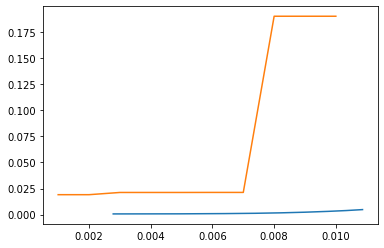

In [133]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)